# 02 — Helmholtz Decomposition & QG Omega

Demonstrates on a real blocking event:

1. 3-D Helmholtz decomposition of anomalous winds → rotational / divergent / harmonic
2. QG omega equation solver
3. Moist / dry omega decomposition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pvtend import helmholtz_decomposition, R_EARTH
from pvtend.helmholtz import helmholtz_decomposition_3d
from pvtend.omega import solve_qg_omega
from pvtend.moist_dry import decompose_omega

## 1  Load event data

In [3]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
d = dict(np.load(f"{DATA_ROOT}/blocking_tmp/onset/dh=+0/track_10_1990030505_dh+0.npz"))

lat = d["lat_vec"]
lon = d["lon_vec_unwrapped"]
levels = d["levels"]
X_rel, Y_rel = d["X_rel"], d["Y_rel"]
print(f"Grid: {lat.shape[0]}×{lon.shape[0]}, {len(levels)} levels")

Grid: 29×49, 9 levels


## 2  Helmholtz decomposition of anomalous wind

In [4]:
u_anom_3d = d["u_anom_3d"]   # (9, 29, 49)
v_anom_3d = d["v_anom_3d"]

result_3d = helmholtz_decomposition_3d(u_anom_3d, v_anom_3d, lat, lon, method="direct")
print("Helmholtz output keys:", sorted(result_3d.keys()))

Helmholtz output keys: ['chi', 'divergence', 'psi', 'u_div', 'u_har', 'u_rot', 'v_div', 'v_har', 'v_rot', 'vorticity']


In [5]:
# Compare with pre-computed NPZ values at 300 hPa
ilev = np.argmin(np.abs(levels - 300))

for comp in ["u_rot", "v_rot", "u_div", "v_div"]:
    npz_key = f"u_anom_{comp.split('_')[1]}_3d" if comp.startswith("u") else f"v_anom_{comp.split('_')[1]}_3d"
    computed = result_3d[comp][ilev]
    stored   = d[npz_key][ilev]
    relerr   = np.nanmean(np.abs(computed - stored)) / (np.nanmean(np.abs(stored)) + 1e-30)
    print(f"  {comp:6s}  rel-err = {relerr:.4e}")

  u_rot   rel-err = 3.6563e-01
  v_rot   rel-err = 4.8542e-01
  u_div   rel-err = 7.4916e-01
  v_div   rel-err = 7.5242e-01


## 3  Visualise rotational vs divergent wind at 300 hPa

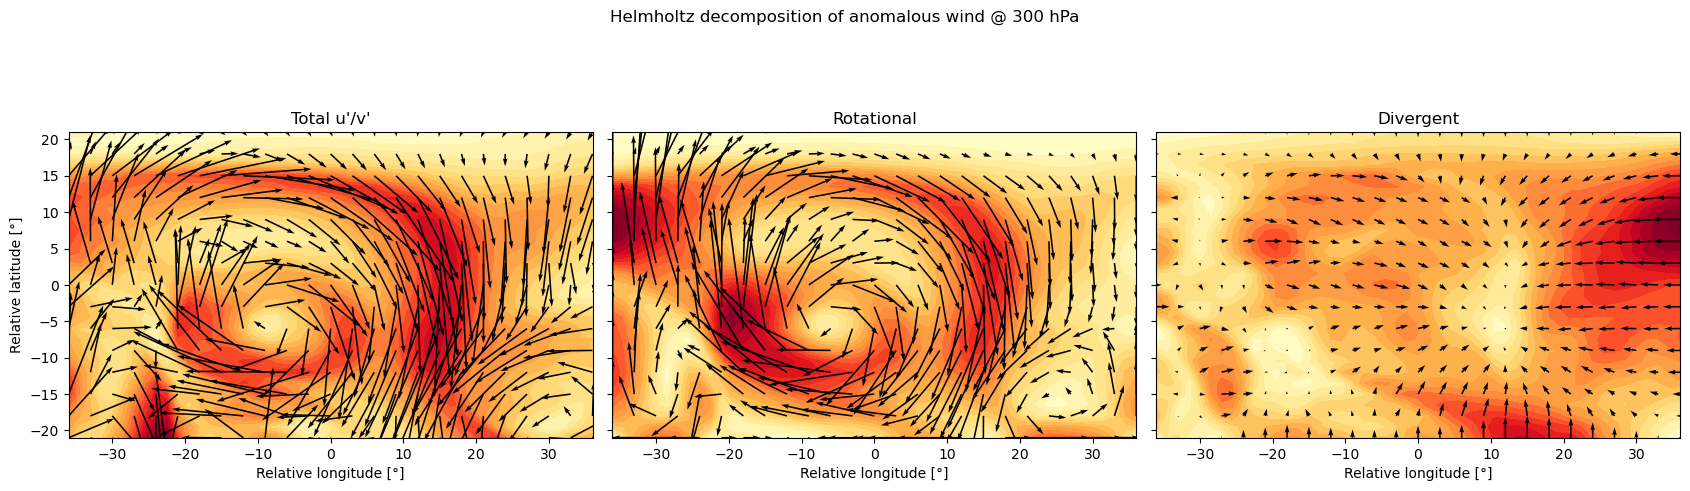

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)
skip = 2
x, y = X_rel[0], Y_rel[:, 0]
xx, yy = np.meshgrid(x, y)

for ax, (title, uk, vk) in zip(axes, [
    ("Total u'/v'", u_anom_3d[ilev], v_anom_3d[ilev]),
    ("Rotational", result_3d["u_rot"][ilev], result_3d["v_rot"][ilev]),
    ("Divergent",  result_3d["u_div"][ilev], result_3d["v_div"][ilev]),
]):
    speed = np.sqrt(uk**2 + vk**2)
    ax.contourf(x, y, speed, levels=20, cmap="YlOrRd", extend="max")
    ax.quiver(xx[::skip, ::skip], yy[::skip, ::skip],
              uk[::skip, ::skip], vk[::skip, ::skip],
              scale=200, width=0.003, color="k")
    ax.set_title(title)
    ax.set_aspect("equal")

axes[0].set_ylabel("Relative latitude [°]")
for ax in axes:
    ax.set_xlabel("Relative longitude [°]")
fig.suptitle("Helmholtz decomposition of anomalous wind @ 300 hPa", y=1.02)
fig.tight_layout()
plt.show()

## 4  QG omega equation — two solver methods

`solve_qg_omega` supports two methods:
- **`method="fft"`** (default): FFT in longitude + Thomas tridiagonal in pressure. Drops ∂²ω/∂y².
- **`method="direct"`**: Full 3-D sparse operator (BiCGSTAB+ILU). Retains both horizontal derivatives.

Optional `center_lat` parameter uses constant f₀ at event centre (Li & O'Gorman 2020 style).

In [7]:
import time

u_3d = d["u_3d"]
v_3d = d["v_3d"]
t_3d = d["t_3d"]
plevs_pa = levels.astype(float) * 100.0

# --- Method A: FFT + Thomas (default) ---
t0 = time.perf_counter()
omega_fft = solve_qg_omega(u_3d, v_3d, t_3d, lat, lon, plevs_pa, method="fft")
t_fft = time.perf_counter() - t0
print(f"FFT solver:    {t_fft:.2f} s  |  range [{omega_fft.min():.3e}, {omega_fft.max():.3e}] Pa/s")

# --- Method B: 3-D direct (BiCGSTAB+ILU) ---
t0 = time.perf_counter()
omega_direct = solve_qg_omega(u_3d, v_3d, t_3d, lat, lon, plevs_pa, method="direct")
t_direct = time.perf_counter() - t0
print(f"3-D solver:    {t_direct:.2f} s  |  range [{omega_direct.min():.3e}, {omega_direct.max():.3e}] Pa/s")

# --- Comparison ---
mask = np.abs(omega_fft) > 1e-10
corr = np.corrcoef(omega_fft[mask].ravel(), omega_direct[mask].ravel())[0, 1]
rmse = np.sqrt(np.mean((omega_fft[mask] - omega_direct[mask])**2))
print(f"\nFFT vs 3-D:  r = {corr:.4f}  |  RMSE = {rmse:.3e} Pa/s")

FFT solver:    0.01 s  |  range [-3.743e+01, 3.743e+01] Pa/s
3-D solver:    0.24 s  |  range [-3.946e+00, 3.980e+00] Pa/s

FFT vs 3-D:  r = 0.7491  |  RMSE = 1.829e+00 Pa/s


In [8]:
# --- With center_lat (Li & O'Gorman 2020 style: constant f0 at event centre) ---
center_lat = float(np.mean(lat))  # approximate event centre

omega_fft_cl = solve_qg_omega(
    u_3d, v_3d, t_3d, lat, lon, plevs_pa,
    method="fft", center_lat=center_lat
)
omega_3d_cl = solve_qg_omega(
    u_3d, v_3d, t_3d, lat, lon, plevs_pa,
    method="direct", center_lat=center_lat
)

corr_cl = np.corrcoef(omega_fft_cl[mask].ravel(), omega_3d_cl[mask].ravel())[0, 1]
print(f"With center_lat={center_lat:.1f}°:")
print(f"  FFT range:    [{omega_fft_cl.min():.3e}, {omega_fft_cl.max():.3e}]")
print(f"  Direct range: [{omega_3d_cl.min():.3e}, {omega_3d_cl.max():.3e}]")
print(f"  FFT vs 3-D:   r = {corr_cl:.4f}")

With center_lat=66.0°:
  FFT range:    [-3.955e+01, 3.960e+01]
  Direct range: [-3.994e+00, 4.052e+00]
  FFT vs 3-D:   r = 0.7476


## 5  Omega cross-section through blocking centre

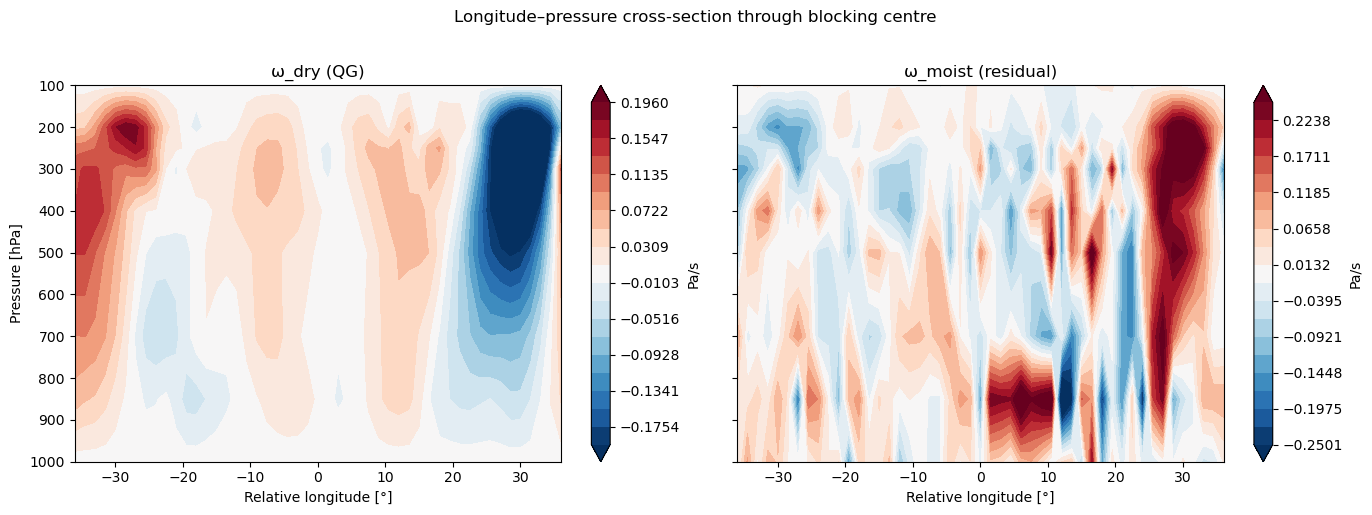

In [ ]:
imid_lat = lat.shape[0] // 2  # centre row

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

omega_dry_stored = d["w_dry_3d"]
omega_moist_stored = d["w_moist_3d"]

for ax, (title, omega) in zip(axes, [
    ("ω_dry (QG)", omega_dry_stored),
    ("ω_moist (residual)", omega_moist_stored),
]):
    vmax = np.nanpercentile(np.abs(omega[:, imid_lat, :]), 95)
    cf = ax.contourf(x, levels, omega[:, imid_lat, :],
                     levels=np.linspace(-vmax, vmax, 20), cmap="RdBu_r", extend="both")
    ax.set_title(title)
    ax.set_xlabel("Relative longitude [°]")
    plt.colorbar(cf, ax=ax, label="Pa/s")

axes[0].set_ylabel("Pressure [hPa]")
axes[0].invert_yaxis()
fig.suptitle("Longitude–pressure cross-section through blocking centre", y=1.02)
fig.tight_layout()
plt.show()

## 6  Moist–dry omega decomposition

In [ ]:
omega_total = d["w_3d"]
omega_dry   = d["w_dry_3d"]

decomp = decompose_omega(omega_total, omega_dry, lat, lon, plevs_pa,
                         u_div=result_3d["u_div"], v_div=result_3d["v_div"])
print("decompose_omega keys:", sorted(decomp.keys()))
print(f"omega_moist range: [{decomp['omega_moist'].min():.3e}, "
      f"{decomp['omega_moist'].max():.3e}] Pa/s")

decompose_omega keys: ['chi_moist', 'omega_moist', 'u_div_dry', 'u_div_moist', 'v_div_dry', 'v_div_moist']
omega_moist range: [-1.303e+00, 1.591e+00] Pa/s


## Summary

- **`helmholtz_decomposition_3d`** splits anomalous wind into rotational (ψ),
  divergent (χ) and harmonic components at every pressure level.
- **`solve_qg_omega`** solves the QG omega equation with **two methods**:
  - `method="fft"` — FFT + Thomas tridiagonal (fast, drops ∂²ω/∂y²)
  - `method="direct"` — Full 3-D sparse BiCGSTAB+ILU (retains full horizontal Laplacian)
  - Optional `center_lat` for constant f₀ at event centre (Li & O'Gorman 2020)
- **`decompose_omega`** partitions ω into dry (QG) and moist (residual) parts,
  optionally computing the divergent-wind contribution of each.